In [1]:
from IPython.core.display import HTML
css_file = '../style/style.css'
HTML(open(css_file, "r").read())

# Workshop on Modelling Tsunamis and Flash Flood Inundation with GeoClaw 

## Part 3: "Propagation of the Chile, 2010 tsunami"

### José Galaz
[https://jgalazm.github.io](https://jgalazm.github.io)

## Introduction

The objective of this workshop is to work on simple cases that may allow the student to experience some example applications of the *GeoClaw* software, completely functional in a virtual machine, and that may serve as starting point to model more complex scenarios.

GeoClaw is a part of [ClawPack](https://www.clawpack.org), a free open source software developed by the University of Washington. It consists of several packages that by means of numerical methods integrate a family of partial differential equations often called **conservation laws**, and hence the name: *ClawPack = Conservation Laws Package*. Geoclaw specializes at solving geophysical problems, as tsunamis, storm-surges amongst others.

In our case, it allows us to solve the initial boundary value problem (IBVP) of the **Non Linear Shallow Water Equations** including **strong variations in topography**, **bottom friction** and handling **shock waves** (discontinuities) by solving a ** Riemann problem** between each cell's interface. Also, to improve the performance of the computations it employes **adaptive grids**, that allow to vary the grid size (say $\Delta x$) both in space and time.

In case you do not understand some of the words in **bold**, I suggest you to investigate. There exists excelent material for studying on the internet, for example that of the [PASI-TSUNAMI course that took place the year 2013 at the Federico Santa María university in Valparaíso, Chile](http://www.bu.edu/pasi-tsunami/materials).

The (excelent) documentation, license information, contribution guidelines (in case you are interested in cooperating as developer), and other topics can be found in the [official site](https://www.clawpack.org).


### How to work with the Jupyter Notebook

[Jupyter notebooks](https://jupyter.org) are documents that can be edited using a web-based user interface. As they describe it

>The Jupyter Notebook is a web application that allows you to create and share documents that contain live code, equations, visualizations and explanatory text

They split their content in cells, which can contain code or formatted text, and you can also write/append its content to a file. At the begining you will probably only work with the toolbar and menus at the top of the page, but what I recommend the most is to memorize some keyboard shortcuts. At least the ones I use are:

* select a cell and press enter: edit the content of the current cell
* esc: exit editing mode
* ctrl + enter: Execute current cell
* shift+ enter: Execute current cell and move to the next one.

When out of edit mode, select a cell and use the following

* m: change cell to normal text mode
* y: change cell to code text mode
* a: insert cell above
* b: insert cell below
* d+d: delete current cell

You can find more in the dropdown menu **Help > Keyboard Shortcuts**

### Overview of this notebook

We will simulate the generation and propagation of a tsunami wave over the pacific ocean. First we shall see how to read the **topography** from an external file. Then we will calculate the deformation of the free-surface due to the movement in a **tectonic fault** produced by an earthquake in the ocean. Before running any calculation, we will set GeoClaw to save **maximum wave amplitude** and **arrival times** at run-time. After that we will **configure** and **run** the simulation. Finally we will see how we can obtain **propagation maps**, **snapshots** of the simulation as also punctual results that may be compared with buoy data for example.

### Disclaimer

The content in this notebook is a modified version of the example available in the [ClawPack web site](http://www.clawpack.org/gallery/gallery_geoclaw.html). Also the style sheets were borrowed from [here](http://openedx.seas.gwu.edu/courses/GW/MAE6286/2014_fall/info).

## Preparing the data for the simulation

### Topography

GeoClaw allows three different formats for the topography which are well documented [here](http://www.clawpack.org/topo.html#topo). For this example, we will use a file already prepared in format number 3. We should remember this number, since we will have to write it in the *setrun.py* file later.

First of all, we import some fundamental python packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

And download the data from the web-site.

In [3]:
from clawpack.geoclaw import topotools
import clawpack.clawutil.data as clawutildata
topo_fname = 'etopo10min120W60W60S0S.asc'
url = 'http://www.geoclaw.org/topo/etopo/' + topo_fname
clawutildata.get_remote_file(url, output_dir='.', file_name=topo_fname,
        verbose=True)

Skipping http://www.geoclaw.org/topo/etopo/etopo10min120W60W60S0S.asc 
  because file already exists: ./etopo10min120W60W60S0S.asc


And we can check the file was properly read by GeoClaw by using the function
    
    topotools.Topography(topo_fname, topotype)

that returns a "Topography" object with the information from the file. We can actually plot it to see how it looks like.

/home/jose/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1215: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if aspect == 'normal':
/home/jose/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:1220: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  elif aspect in ('equal', 'auto'):


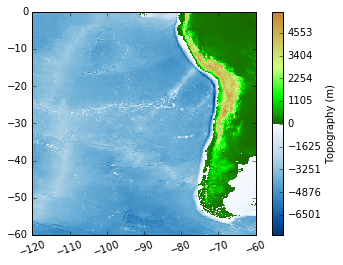

In [4]:
topo = topotools.Topography(topo_fname, topo_type=2)
topo.plot()

### From tectonic fault to free surface deformation

GeoClaw has implemented the dislocation model proposed by Okada ("Surface deformation due to Shear and Tensile Faults in a Half Space", Bulletin of the Seismological Society of America, Vol. 75, No. 4, pp. 1135-1154, August 1985 ) to convert the rupture characterized by a set of geophysical parameters into free surface initial amplitude.

We initialize our fault object

In [5]:
from clawpack.geoclaw import dtopotools
fault = dtopotools.Fault()

Due to the linear nature of the problem solved in the Okada model, the total deformation results from the superposition of a finite number of disjoint "subfaults". In our case, we will simulate using the homogeneous fault proposed by the USGS for the 2010 event of Chile. This means we will use only one subfault.

Define a subfault

In [6]:
# Specify subfault parameters for this simple fault model consisting
# of a single subfault:
usgs_subfault = dtopotools.SubFault()
usgs_subfault.strike = 16.
usgs_subfault.length = 450.e3
usgs_subfault.width = 100.e3
usgs_subfault.depth = 35.e3
usgs_subfault.slip = 15.
usgs_subfault.rake = 104.
usgs_subfault.dip = 14.
usgs_subfault.longitude = -72.668
usgs_subfault.latitude = -35.826
usgs_subfault.coordinate_specification = "top center"

And add it to the collection of subfaults of our fault object

In [7]:
fault.subfaults = [usgs_subfault]

It can be interesting to ask how is the energy level of this scenario

In [8]:
print "Mw = ",fault.Mw()

Mw =  8.92090917611


Now we can calculate the initial deformation of the water free surface, and write it to a file

In [9]:
import os
dtopo_fname = os.path.join('.', "dtopo_usgs100227.tt3")
if os.path.exists(dtopo_fname):
    print "*** Not regenerating dtopo file (already exists): %s" \
                % dtopo_fname
else:
    print "Using Okada model to create dtopo file"

    x = np.linspace(-77, -67, 100)
    y = np.linspace(-40, -30, 100)
    times = [1.]

    fault.create_dtopography(x,y,times)
    dtopo = fault.dtopo
    dtopo.write(dtopo_fname, dtopo_type=3)

*** Not regenerating dtopo file (already exists): ./dtopo_usgs100227.tt3


Now we can compare graphically the *slip* distribution of the fault model, with the generated vertical displacement of the free surface. In the next cell, the most important line is that which contains the *dtopo.plot_dZ_colors.*, since the others are only *matplotlib* commands to make the figure prettier or for keeping the sanity of the data.

Reading in dtopo file...


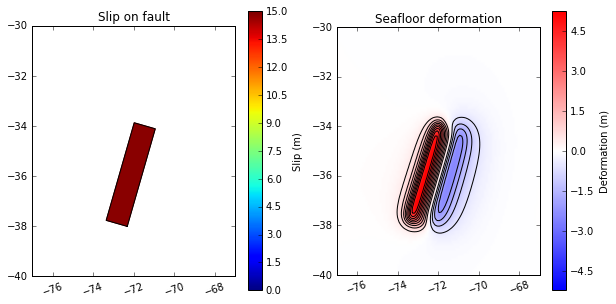

In [10]:
if fault.dtopo is None:
    # read in the pre-existing file:
    print "Reading in dtopo file..."
    dtopo = dtopotools.DTopography()
    dtopo.read(dtopo_fname, dtopo_type=3)
    x = dtopo.x
    y = dtopo.y
plt.figure(figsize=(10,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
fault.plot_subfaults(axes=ax1,slip_color=True)
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(y.min(),y.max())


#the important one
dtopo.plot_dZ_colors(1.,axes=ax2)

## Configuring the simulation parameters and options

### Save maximum heights and arrival times *on the run*

To save time, GeoClaw allows to trace the maximum heights and their times of occurence at run-time, which can save a significant amount of time when processing the output.  For this, it is neccessary to create an *fgmax* file as follows.

It is indeed not a trivial task to do, since we have different grid sizes in space that also vary in time.

In [11]:
from clawpack.geoclaw import fgmax_tools
fg = fgmax_tools.FGmaxGrid()
fg.point_style = 2       # will specify a 2d grid of points
fg.x1 = -120.
fg.x2 = -60.
fg.y1 = -60.
fg.y2 = 0.
fg.dx = 0.2 
fg.tstart_max =  10.     # when to start monitoring max values
fg.tend_max = 1.e10       # when to stop monitoring max values
fg.dt_check = 60.         # target time (sec) increment between updating 
                           # max values
fg.min_level_check = 2    # which levels to monitor max on
fg.arrival_tol = 1.e-2    # tolerance for flagging arrival

fg.input_file_name = 'fgmax_grid.txt'
fg.write_input_data()

---------------------------------------------- 
Created file  fgmax_grid.txt
   specifying fixed grid with shape 301 by 301, with  90601 points
   lower left  = (-120.0000000000, -60.0000000000)
   upper right = ( -60.0000000000,   0.0000000000)
   dx = 2.0000000000e-01,  dy = 2.0000000000e-01
Box:   -120.000000  -60.000000  -60.000000    0.000000
Created  fgmax_grid.kml


### Setting a simulation run: the setrun.py file

To run a simulation we need to define a python script called *setrun.py* file. Also it is mandatory to have in the same folder a file called **Makefile** which you won't need to edit, but only to make sure it is there: this is the one responsible for gathering and translating all the code into a machine executable file. On the other side, through the *setrun.py* we will define all the parameters such as simulation final time, and link the topography and initial condition data files we created before.

You will see the *setrun.py* is quite long, but there is only a few sections we are commonly interested on editing.

#### A comment on adaptive refinement with GeoClaw

GeoClaw asks you to define refinement regions that define the extent in space and time, over which you want to allow it to use finer grids. What you have to define beforehand is:

1. A list of **refinement ratios** (integer numbers), say $r_x =[r_2,...,r_l]$, with $l$ the number of **refinement levels** in the simulation, such that $$\dfrac{\Delta x_{1}}{\Delta x_{2}} = r_1, \dfrac{\Delta x_{2}}{\Delta x_{3}} = r_2$$, and so on. Notice that $\Delta x_1$ is the cell size of the coarsest level, which covers the full domain.

2. (optional) A list of **refinement regions** with min and max level of  refinement level allowed in a rectangle inside the domain, for a given time interval of the simulation.

Given the restrictions in 2., GeoClaw will try to refine up to the highest level defined in 1, when a specific criteria is satisfied. If you don't define 2., GeoClaw will assume you allow the maximum level of refinement everywhere. The criteria of refinement is when the amplitude of the wave, with respect to the default sea-level is greater than a defined tolerance (of course, the tolerance is also defined in the setrun.py).

I suggest you to read the setrun.py carefully once, but then just "ctrl+f" the section enclosed in "#-----" that is of your interest

### The setrun.py file

This is the most important file, and all of its fields are well explained in detail [here](http://www.clawpack.org/setrun.html). Those which are of most interest to us can be found in the following sections:


* Extent of the computational domain, and resolution of the coarser level.

        # ---------------
        # Spatial domain:
        # ---------------

        ...

* Simulation instants when you want to save the whole simulation state to a file. Be careful with this, since it can grow large very easily.

        # -------------
        # Output times:
        #--------------

        ...

* Time step configuration of the simulation. Normally you will only edit the "CFL_..." parameters, when the computation misteriously "blows up".

        # --------------
        # Time stepping:
        # --------------

        ...

* Boundary conditions: There is only "closed" (reflective) and "open" (extrapolation) boundaries. More complex boundary conditions must be programed in fortran by the user.

        # --------------------
        # Boundary conditions:
        # --------------------

        ...


* Adaptive Refinement parameters and **output virtual gauges location**.

        # ---------------
        # AMR parameters:
        # ---------------   

        ...
    
* Other geophysical related parameters such as the **wave_tolerance** for adaptive refinement, bottom friction, coordinate sistem (lat-lon or cartesian), amongst others.

        #-------------------
        def setgeo(rundata):
        #-------------------    
        ...         

I suggest you to read the setrun.py carefully once, but then just "ctrl+f" the section enclosed in "#-----" that is of your interest

### Editing the setrun.py file

We will use the ipython %%writefile magic function, this will allow us to write all the content in a cell (except for the first line) in the specified file.

If you are wondering, I just copy-pasted an existing setrun.py file from the geoclaw examples directory, and then modified its content to fulfill this requirements of this example.

You can execute

    %%writefile?

to see its docstring.    

In [12]:
%%writefile setrun.py
# %load setrun.py
"""
Module to set up run time parameters for Clawpack.

The values set in the function setrun are then written out to data files
that will be read in by the Fortran code.

"""

import os
import numpy as np

try:
    CLAW = os.environ['CLAW']
except:
    raise Exception("*** Must first set CLAW enviornment variable")


#------------------------------
def setrun(claw_pkg='geoclaw'):
#------------------------------

    """
    Define the parameters used for running Clawpack.

    INPUT:
        claw_pkg expected to be "geoclaw" for this setrun.

    OUTPUT:
        rundata - object of class ClawRunData

    """

    from clawpack.clawutil import data

    assert claw_pkg.lower() == 'geoclaw',  "Expected claw_pkg = 'geoclaw'"

    num_dim = 2
    rundata = data.ClawRunData(claw_pkg, num_dim)


    #------------------------------------------------------------------
    # Problem-specific parameters to be written to setprob.data:
    #------------------------------------------------------------------
    
    #probdata = rundata.new_UserData(name='probdata',fname='setprob.data')


    #------------------------------------------------------------------
    # GeoClaw specific parameters:
    #------------------------------------------------------------------
    rundata = setgeo(rundata)

    #------------------------------------------------------------------
    # Standard Clawpack parameters to be written to claw.data:
    #   (or to amr2ez.data for AMR)
    #------------------------------------------------------------------
    clawdata = rundata.clawdata  # initialized when rundata instantiated


    # Set single grid parameters first.
    # See below for AMR parameters.


    # ---------------
    # Spatial domain:
    # ---------------

    # Number of space dimensions:
    clawdata.num_dim = num_dim

    # Lower and upper edge of computational domain:
    clawdata.lower[0] = -120.0      # west longitude
    clawdata.upper[0] = -60.0       # east longitude

    clawdata.lower[1] = -60.0       # south latitude
    clawdata.upper[1] = 0.0         # north latitude



    # Number of grid cells: Coarsest grid
    clawdata.num_cells[0] = 30
    clawdata.num_cells[1] = 30

    # ---------------
    # Size of system:
    # ---------------

    # Number of equations in the system:
    clawdata.num_eqn = 3

    # Number of auxiliary variables in the aux array (initialized in setaux)
    clawdata.num_aux = 4

    # Index of aux array corresponding to capacity function, if there is one:
    clawdata.capa_index = 2

    
    
    # -------------
    # Initial time:
    # -------------

    clawdata.t0 = 0.0


    # Restart from checkpoint file of a previous run?
    # Note: If restarting, you must also change the Makefile to set:
    #    RESTART = True
    # If restarting, t0 above should be from original run, and the
    # restart_file 'fort.chkNNNNN' specified below should be in 
    # the OUTDIR indicated in Makefile.

    clawdata.restart = False               # True to restart from prior results
    clawdata.restart_file = 'fort.chk00036'  # File to use for restart data

    # -------------
    # Output times:
    #--------------

    # Specify at what times the results should be written to fort.q files.
    # Note that the time integration stops after the final output time.
    # The solution at initial time t0 is always written in addition.

    clawdata.output_style = 1

    if clawdata.output_style==1:
        # Output nout frames at equally spaced times up to tfinal:
        clawdata.num_output_times = 5
        clawdata.tfinal = 10*3600.0
        clawdata.output_t0 = False  # output at initial (or restart) time?

    elif clawdata.output_style == 2:
        # Specify a list of output times.
        clawdata.output_times = [30., 60., 300., 600.]

    elif clawdata.output_style == 3:
        # Output every iout timesteps with a total of ntot time steps:
        clawdata.output_step_interval = 1
        clawdata.total_steps = 3
        clawdata.output_t0 = True
        

    clawdata.output_format = 'ascii'      # 'ascii' or 'netcdf' 

    clawdata.output_q_components = 'all'   # need all
    clawdata.output_aux_components = 'none'  # eta=h+B is in q
    clawdata.output_aux_onlyonce = False    # output aux arrays each frame



    # ---------------------------------------------------
    # Verbosity of messages to screen during integration:
    # ---------------------------------------------------

    # The current t, dt, and cfl will be printed every time step
    # at AMR levels <= verbosity.  Set verbosity = 0 for no printing.
    #   (E.g. verbosity == 2 means print only on levels 1 and 2.)
    clawdata.verbosity = 1



    # --------------
    # Time stepping:
    # --------------

    # if dt_variable==1: variable time steps used based on cfl_desired,
    # if dt_variable==0: fixed time steps dt = dt_initial will always be used.
    clawdata.dt_variable = True

    # Initial time step for variable dt.
    # If dt_variable==0 then dt=dt_initial for all steps:
    clawdata.dt_initial = 0.2

    # Max time step to be allowed if variable dt used:
    clawdata.dt_max = 1e+99

    # Desired Courant number if variable dt used, and max to allow without
    # retaking step with a smaller dt:
    clawdata.cfl_desired = 0.75
    clawdata.cfl_max = 1.0

    # Maximum number of time steps to allow between output times:
    clawdata.steps_max = 5000




    # ------------------
    # Method to be used:
    # ------------------

    # Order of accuracy:  1 => Godunov,  2 => Lax-Wendroff plus limiters
    clawdata.order = 2
    
    # Use dimensional splitting? (not yet available for AMR)
    clawdata.dimensional_split = 'unsplit'
    
    # For unsplit method, transverse_waves can be 
    #  0 or 'none'      ==> donor cell (only normal solver used)
    #  1 or 'increment' ==> corner transport of waves
    #  2 or 'all'       ==> corner transport of 2nd order corrections too
    clawdata.transverse_waves = 2

    # Number of waves in the Riemann solution:
    clawdata.num_waves = 3
    
    # List of limiters to use for each wave family:  
    # Required:  len(limiter) == num_waves
    # Some options:
    #   0 or 'none'     ==> no limiter (Lax-Wendroff)
    #   1 or 'minmod'   ==> minmod
    #   2 or 'superbee' ==> superbee
    #   3 or 'mc'       ==> MC limiter
    #   4 or 'vanleer'  ==> van Leer
    clawdata.limiter = ['mc', 'mc', 'mc']

    clawdata.use_fwaves = True    # True ==> use f-wave version of algorithms
    
    # Source terms splitting:
    #   src_split == 0 or 'none'    ==> no source term (src routine never called)
    #   src_split == 1 or 'godunov' ==> Godunov (1st order) splitting used, 
    #   src_split == 2 or 'strang'  ==> Strang (2nd order) splitting used,  not recommended.
    clawdata.source_split = 'godunov'


    # --------------------
    # Boundary conditions:
    # --------------------

    # Number of ghost cells (usually 2)
    clawdata.num_ghost = 2

    # Choice of BCs at xlower and xupper:
    #   0 => user specified (must modify bcN.f to use this option)
    #   1 => extrapolation (non-reflecting outflow)
    #   2 => periodic (must specify this at both boundaries)
    #   3 => solid wall for systems where q(2) is normal velocity

    clawdata.bc_lower[0] = 'extrap'
    clawdata.bc_upper[0] = 'extrap'

    clawdata.bc_lower[1] = 'extrap'
    clawdata.bc_upper[1] = 'extrap'



    # --------------
    # Checkpointing:
    # --------------

    # Specify when checkpoint files should be created that can be
    # used to restart a computation.

    clawdata.checkpt_style = 0

    if clawdata.checkpt_style == 0:
        # Do not checkpoint at all
        pass

    elif clawdata.checkpt_style == 1:
        # Checkpoint only at tfinal.
        pass

    elif clawdata.checkpt_style == 2:
        # Specify a list of checkpoint times.  
        clawdata.checkpt_times = [0.1,0.15]

    elif clawdata.checkpt_style == 3:
        # Checkpoint every checkpt_interval timesteps (on Level 1)
        # and at the final time.
        clawdata.checkpt_interval = 5


    # ---------------
    # AMR parameters:
    # ---------------
    amrdata = rundata.amrdata

    # max number of refinement levels:
    amrdata.amr_levels_max = 2

    # List of refinement ratios at each level (length at least mxnest-1)
    amrdata.refinement_ratios_x = [4,3]
    amrdata.refinement_ratios_y = [4,3]
    amrdata.refinement_ratios_t = [4,3]


    # Specify type of each aux variable in amrdata.auxtype.
    # This must be a list of length maux, each element of which is one of:
    #   'center',  'capacity', 'xleft', or 'yleft'  (see documentation).

    amrdata.aux_type = ['center','capacity','yleft','center']


    # Flag using refinement routine flag2refine rather than richardson error
    amrdata.flag_richardson = False    # use Richardson?
    amrdata.flag2refine = True

    # steps to take on each level L between regriddings of level L+1:
    amrdata.regrid_interval = 3

    # width of buffer zone around flagged points:
    # (typically the same as regrid_interval so waves don't escape):
    amrdata.regrid_buffer_width  = 2

    # clustering alg. cutoff for (# flagged pts) / (total # of cells refined)
    # (closer to 1.0 => more small grids may be needed to cover flagged cells)
    amrdata.clustering_cutoff = 0.700000

    # print info about each regridding up to this level:
    amrdata.verbosity_regrid = 0  

    #  ----- For developers ----- 
    # Toggle debugging print statements:
    amrdata.dprint = False      # print domain flags
    amrdata.eprint = False      # print err est flags
    amrdata.edebug = False      # even more err est flags
    amrdata.gprint = False      # grid bisection/clustering
    amrdata.nprint = False      # proper nesting output
    amrdata.pprint = False      # proj. of tagged points
    amrdata.rprint = False      # print regridding summary
    amrdata.sprint = False      # space/memory output
    amrdata.tprint = True       # time step reporting each level
    amrdata.uprint = False      # update/upbnd reporting
    
    # More AMR parameters can be set -- see the defaults in pyclaw/data.py

    # ---------------
    # Regions:
    # ---------------
    rundata.regiondata.regions = []
    # to specify regions of refinement append lines of the form
    #  [minlevel,maxlevel,t1,t2,x1,x2,y1,y2]
    #rundata.regiondata.regions.append([1, 2, 0., 1e9, -360,360,-90,90])
    rundata.regiondata.regions.append([3, 3, 0., 600., -76,-72,-38,-33])

    # ---------------
    # Gauges:
    # ---------------
    rundata.gaugedata.gauges = []
    # for gauges append lines of the form  [gaugeno, x, y, t1, t2]
    rundata.gaugedata.gauges.append([32412, -86.392, -17.975, 0., 1.e10])
    

    return rundata
    # end of function setrun
    # ----------------------


#-------------------
def setgeo(rundata):
#-------------------
    """
    Set GeoClaw specific runtime parameters.
    For documentation see ....
    """

    try:
        geo_data = rundata.geo_data
    except:
        print "*** Error, this rundata has no geo_data attribute"
        raise AttributeError("Missing geo_data attribute")
       
    # == Physics ==
    geo_data.gravity = 9.81
    geo_data.coordinate_system = 2
    geo_data.earth_radius = 6367.5e3

    # == Forcing Options
    geo_data.coriolis_forcing = False

    # == Algorithm and Initial Conditions ==
    geo_data.sea_level = 0.0
    geo_data.dry_tolerance = 1.e-3
    geo_data.friction_forcing = True
    geo_data.manning_coefficient =.025
    geo_data.friction_depth = 1e6

    # Refinement settings
    refinement_data = rundata.refinement_data
    refinement_data.variable_dt_refinement_ratios = True
    refinement_data.wave_tolerance = 1.e-2
    refinement_data.deep_depth = 1e2
    refinement_data.max_level_deep = 3

    # == settopo.data values ==
    topo_data = rundata.topo_data
    # for topography, append lines of the form
    #    [topotype, minlevel, maxlevel, t1, t2, fname]
    topo_path = './etopo10min120W60W60S0S.asc'
    topo_data.topofiles.append([2, 1, 3, 0., 1.e10, topo_path])

    # == setdtopo.data values ==
    dtopo_data = rundata.dtopo_data
    # for moving topography, append lines of the form :   (<= 1 allowed for now!)
    #   [topotype, minlevel,maxlevel,fname]
    dtopo_path = './dtopo_usgs100227.tt3'
    dtopo_data.dtopofiles.append([3,3,3,dtopo_path])
    dtopo_data.dt_max_dtopo = 0.2


    # == setqinit.data values ==
    rundata.qinit_data.qinit_type = 0
    rundata.qinit_data.qinitfiles = []
    # for qinit perturbations, append lines of the form: (<= 1 allowed for now!)
    #   [minlev, maxlev, fname]

    # == setfixedgrids.data values ==
    fixed_grids = rundata.fixed_grid_data
    # for fixed grids append lines of the form
    # [t1,t2,noutput,x1,x2,y1,y2,xpoints,ypoints,\
    #  ioutarrivaltimes,ioutsurfacemax]

    # == fgmax.data values ==
    fgmax_files = rundata.fgmax_data.fgmax_files
    # for fixed grids append to this list names of any fgmax input files
    fgmax_files.append('fgmax_grid.txt')
    rundata.fgmax_data.num_fgmax_val = 1  # Save depth only



    return rundata
    # end of function setgeo
    # ----------------------



if __name__ == '__main__':
    # Set up run-time parameters and write all data files.
    import sys
    rundata = setrun(*sys.argv[1:])
    rundata.write()



Overwriting setrun.py


## Running the simulation

Once the setrun.py is ready we will use some commands defined in the **Makefile** that should be in the same folder as this notebook. The Makefile will compile the Fortran source code and create an executable that will also be called from the Makefile command.

You can see which commands are defined in the Makefile by executing from a terminal

    make help

or simply put a "!" in an ipython cell, to run as if it was from the terminal

In [13]:
!make help

Makefile:187: warning: overriding commands for target `all'
/home/jose/Downloads/clawpack-5.3.1//clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
   "make .objs"    to compile object files
   "make .exe"     to create executable
   "make .data"    to create data files using setrun.py
   "make .output"  to run code
   "make output"   to run code with no dependency checking
   "make .plots"   to produce plots
   "make plots"    to produce plots with no dependency checking
   "make .htmls"   to produce html versions of files
   "make .program" to produce single program file
   "make new"      to remove all objs and then make .exe
   "make clean"    to clean up compilation and html files
   "make clobber"  to also clean up output and plot files
   "make help"     to print this message


The following cell will delete any precompiled files with the

    make clean

command, and compile the code again and execute it with

    make .output

You can write the magic
    
    %%capture out
    
in the first line, if you find the screen output too annoying, and save it in the "out" variable.

Now sit back, and wait for those results.

In [14]:
%%capture out
!make clean
!make .output

Using only two refinement levels, it took me about 40 seconds to run.

## Processing the results: GeoClaw predefined plotting functions

There are two kind of figures we can generate with GeoClaw for tsunamis: the standard snapshots of the simulation and output gauges, and propagation maps showing the maximum height of the wave and its arrival times.

### Creating animations and punctual time series with results

To easily generate some nice figures we have to configure the *setplot.py* file. All figures will be generated in the folder

    ./_plots

We shall proceed just as with the setrun.py file.

Notice that snapshots values are taken from the stored values at times defined in the section

        # -------------
        # Output times:
        #--------------

        ...
        
in the *setrun.py* file.

Also, if you read the *setplot.py* file you will notice that snapshot figures are defined in the section

    #-----------------------------------------
    # Figure for surface
    #-----------------------------------------
    ...
and output gauges in


    #-----------------------------------------
    # Figures for gauges
    #-----------------------------------------


In [15]:
%%writefile setplot.py
# %load setplot.py

""" 
Set up the plot figures, axes, and items to be done for each frame.

This module is imported by the plotting routines and then the
function setplot is called to set the plot parameters.
    
""" 

import numpy as np
import matplotlib.pyplot as plt

from clawpack.geoclaw import topotools

try:
    TG32412 = np.loadtxt('32412_notide.txt')
except:
    print "*** Could not load DART data file"

#--------------------------
def setplot(plotdata):
#--------------------------
    
    """ 
    Specify what is to be plotted at each frame.
    Input:  plotdata, an instance of pyclaw.plotters.data.ClawPlotData.
    Output: a modified version of plotdata.
    
    """ 


    from clawpack.visclaw import colormaps, geoplot
    from numpy import linspace

    plotdata.clearfigures()  # clear any old figures,axes,items data


    # To plot gauge locations on pcolor or contour plot, use this as
    # an afteraxis function:

    def addgauges(current_data):
        from clawpack.visclaw import gaugetools
        gaugetools.plot_gauge_locations(current_data.plotdata, \
             gaugenos='all', format_string='ko', add_labels=True)
    

    #-----------------------------------------
    # Figure for surface
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Surface', figno=0)

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes('pcolor')
    plotaxes.title = 'Surface'
    plotaxes.scaled = True

    def fixup(current_data):
        import pylab
        addgauges(current_data)
        t = current_data.t
        t = t / 3600.  # hours
        pylab.title('Surface at %4.2f hours' % t, fontsize=20)
        pylab.xticks(fontsize=15)
        pylab.yticks(fontsize=15)
    plotaxes.afteraxes = fixup

    # Water
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    #plotitem.plot_var = geoplot.surface
    plotitem.plot_var = geoplot.surface_or_depth
    plotitem.pcolor_cmap = geoplot.tsunami_colormap
    plotitem.pcolor_cmin = -0.2
    plotitem.pcolor_cmax = 0.2
    plotitem.add_colorbar = True
    plotitem.amr_celledges_show = [0,0,0]
    plotitem.patchedges_show = 1

    # Land
    plotitem = plotaxes.new_plotitem(plot_type='2d_pcolor')
    plotitem.plot_var = geoplot.land
    plotitem.pcolor_cmap = geoplot.land_colors
    plotitem.pcolor_cmin = 0.0
    plotitem.pcolor_cmax = 100.0
    plotitem.add_colorbar = False
    plotitem.amr_celledges_show = [1,0,0]
    plotitem.patchedges_show = 1
    plotaxes.xlimits = [-120,-60]
    plotaxes.ylimits = [-60,0]

    # add contour lines of bathy if desired:
    plotitem = plotaxes.new_plotitem(plot_type='2d_contour')
    plotitem.show = False
    plotitem.plot_var = geoplot.topo
    plotitem.contour_levels = linspace(-3000,-3000,1)
    plotitem.amr_contour_colors = ['y']  # color on each level
    plotitem.kwargs = {'linestyles':'solid','linewidths':2}
    plotitem.amr_contour_show = [1,0,0]  
    plotitem.celledges_show = 0
    plotitem.patchedges_show = 0


    #-----------------------------------------
    # Figures for gauges
    #-----------------------------------------
    plotfigure = plotdata.new_plotfigure(name='Surface at gauges', figno=300, \
                    type='each_gauge')
    plotfigure.clf_each_gauge = True

    # Set up for axes in this figure:
    plotaxes = plotfigure.new_plotaxes()
    plotaxes.xlimits = 'auto'
    plotaxes.ylimits = 'auto'
    plotaxes.title = 'Surface'

    # Plot surface as blue curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.plot_var = 3
    plotitem.plotstyle = 'b-'

    # Plot topo as green curve:
    plotitem = plotaxes.new_plotitem(plot_type='1d_plot')
    plotitem.show = False

    def gaugetopo(current_data):
        q = current_data.q
        h = q[0,:]
        eta = q[3,:]
        topo = eta - h
        return topo
        
    plotitem.plot_var = gaugetopo
    plotitem.plotstyle = 'g-'

    def add_zeroline(current_data):
        from pylab import plot, legend, xticks, floor, axis, xlabel
        t = current_data.t 
        gaugeno = current_data.gaugeno

        if gaugeno == 32412:
            try:
                plot(TG32412[:,0], TG32412[:,1], 'r')
                legend(['GeoClaw','Obs'],'lower right')
            except: pass
            axis((0,t.max(),-0.3,0.3))

        plot(t, 0*t, 'k')
        n = int(floor(t.max()/3600.) + 2)
        xticks([3600*i for i in range(n)], ['%i' % i for i in range(n)])
        xlabel('time (hours)')

    plotaxes.afteraxes = add_zeroline


    #-----------------------------------------
    # Figures for fgmax - max values on fixed grids
    #-----------------------------------------
    otherfigure = plotdata.new_otherfigure(name='max amplitude and arrival times', 
                    fname='amplitude_times.png')



    #-----------------------------------------
    
    # Parameters used only when creating html and/or latex hardcopy
    # e.g., via pyclaw.plotters.frametools.printframes:

    plotdata.printfigs = True                # print figures
    plotdata.print_format = 'png'            # file format
    plotdata.print_framenos = 'all'          # list of frames to print
    plotdata.print_gaugenos = 'all'          # list of gauges to print
    plotdata.print_fignos = 'all'            # list of figures to print
    plotdata.html = True                     # create html files of plots?
    plotdata.html_homelink = '../README.html'   # pointer for top of index
    plotdata.latex = True                    # create latex file of plots?
    plotdata.latex_figsperline = 2           # layout of plots
    plotdata.latex_framesperline = 1         # layout of plots
    plotdata.latex_makepdf = False           # also run pdflatex?

    return plotdata



Overwriting setplot.py


And again, we will use the **make plots** command from the **Makefile** to generate the figures defined in the **setplot.py** file (don't forget the "!" at the beginning).

In [16]:
!make plots

Makefile:187: warning: overriding commands for target `all'
/home/jose/Downloads/clawpack-5.3.1//clawutil/src/Makefile.common:259: warning: ignoring old commands for target `all'
rm -f .plots
python /home/jose/Downloads/clawpack-5.3.1//visclaw/src/python/visclaw/plotclaw.py _output                _plots                setplot.py      
Importing setplot.setplot from /home/jose/github/tsunami_workshop/en/tsunami.
*** Could not load DART data file
*** Could not load DART data file
Executed setplot successfully
Will plot 5 frames numbered: [1, 2, 3, 4, 5]
Will make 1 figure(s) for each frame, numbered:  [0]

-----------------------------------


Creating html pages for figures...

Directory '/home/jose/github/tsunami_workshop/en/tsunami/_plots' 
    already exists, files may be overwritten 
Now making png files for all figures...
    Reading  Frame 1 at t = 7200  from outdir = /home/jose/github/tsunami_workshop/en/tsunami/_output
Frame 1 at time t = 7200.0
    Reading  Frame 2 at t = 14400

### The animation

The animation that resulted from this *setplot.py* can be loaded here as an *iframe* element of IPython.

In [17]:
from IPython.display import IFrame
IFrame('_plots/movieframe_allframesfig0.html',width=600, height=600)

### The gauge

The virtual gauge can be shown here using the Image command from IPython.

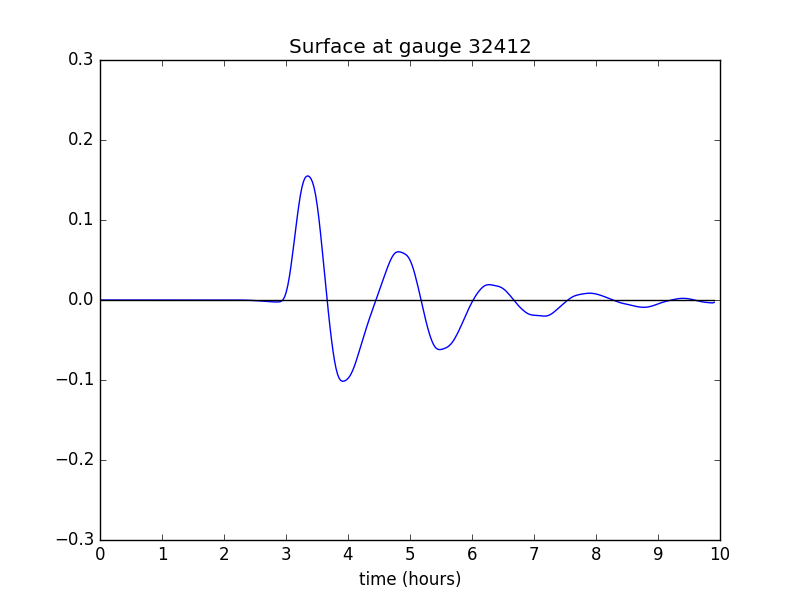

In [18]:
from IPython.display import Image
Image('_plots/gauge32412fig300.png', width=600)

### Propagation map: Maximum heights and arrival times

Finally, to generate the propagation map, we have to load the *fgmax* data we created before running the simulation

In [19]:
from clawpack.geoclaw import fgmax_tools, geoplot
fg = fgmax_tools.FGmaxGrid()
fg.read_input_data('fgmax_grid.txt')


and with this we can read the generated output just by doing

In [20]:
fg.read_output()

Reading _output/fort.FG1.valuemax ...
Reading _output/fort.FG1.aux1 ...


Notice that these results were stored in the *fort.FG1.valuemax* and *fort.FG1.aux1* files in the *_output* folder.

Now we have load the data, we can produce a nice figure with the matplotlib.pyplot functions.

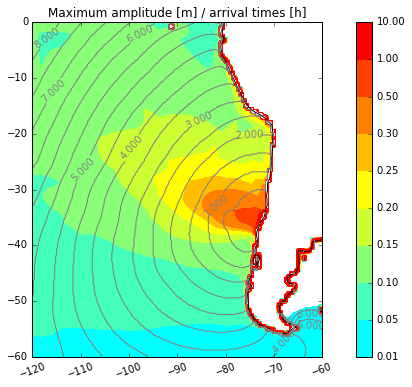

In [21]:
clines_zeta = [0.01] + list(np.linspace(0.05,0.3,6)) + [0.5,1.0,10.0]
colors = geoplot.discrete_cmap_1(clines_zeta)


plt.figure(figsize=(12,6))
plt.clf()
zeta = np.where(fg.B>0, fg.h, fg.h+fg.B)   # surface elevation in ocean
plt.contourf(fg.X,fg.Y,zeta,clines_zeta,colors=colors)
plt.colorbar()
plt.contour(fg.X,fg.Y,fg.B,[0.],colors='k')  # coastline

# plot arrival time contours and label:
arrival_t = fg.arrival_time/3600.  # arrival time in hours
clines_t = np.linspace(0,8,17)  # hours
clines_t_label = clines_t[::2]  # which ones to label 
clines_t_colors = ([.5,.5,.5],)
con_t = plt.contour(fg.X,fg.Y,arrival_t, clines_t,colors=clines_t_colors) 
plt.clabel(con_t, clines_t_label)

# fix axes:
plt.ticklabel_format(format='plain',useOffset=False)
plt.xticks(rotation=20)
plt.gca().set_aspect(1./np.cos(fg.Y.mean()*np.pi/180.))
plt.title("Maximum amplitude [m] / arrival times [h]")

#### THE END